***
# <font color=red>Fraud Detection Prediction Using OCI Data Science Platform</font>
<p style="margin-left:10%; margin-right:10%;"></p>

***

## Modules:

- <a href='#AutoML'>1. Build a ML Model Using AutoML in Oracle ADS (Accelerated Data Science)</a>
- <a href='#Sklearn'>2. Build a ML Model Using Scikit-Learn (Open Source)</a>
- <a href='#ModelCatalog'>3. (Bonus) Save Models To Oracle Model Catalog </a>
- <a href='#ADB'>4. (Bonus) Create an ADB Connection</a>

<a id='AutoML'></a>
## Build a ML Model Using AutoML in ADS (Accelerated Data Science)

### Loading Necessary Libraries And Datasets

In [1]:
%matplotlib inline

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.dataset_browser import DatasetBrowser
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML

Using TensorFlow backend.


In [2]:
import pandas as pd

df = pd.read_csv('sampleDataset.csv')
df = df[['fraudFlag','AGE', 'INCOME', 'EDUCATION_LEVEL', 'merchantType', 'OCCUPATION', 'CREDIT_SCORE_BIN', 'MARITAL_STATUS', 'amount', 'latitude', 'longitude', 'CUSTOMER_ID']]

In [3]:
from ads.dataset.factory import DatasetFactory

df.sample(frac=1)
test = df.loc[:5000]
train = df.loc[5000:]

try:
    train.drop('Unnamed: 0', axis = 1, inplace = True)
    test.drop('Unnamed: 0', axis = 1, inplace = True)
except:
    train.dropna(how='any', axis = 0)
    test.dropna(how='any', axis =0)
    print('the dataset is clean')
    
train = DatasetFactory.open(train, target="fraudFlag")

the dataset is clean


### Viewing the dataset and suggesting EDA using ADS 

In [4]:
train.show_in_notebook()

Accordion(children=(HTML(value='<h1>Name: DataFrame</h1><h3>Type: BinaryClassificationDataset</h3><h3>172,216 …

In [5]:
train.suggest_recommendations()

Code
Message                                  Variables        Suggested                         Action                                                                    
Contains missing values(99)              AGE              Fill missing values with frequent Drop                                                .drop_columns(["AGE"])
                                                                                            Fill missing values with frequent                   .fillna({"AGE": 63.0})
                                                                                            Fill missing values with constant             .fillna({"AGE": "constant"})
                                                                                            Do nothing                                                                
Contains missing values(133)             INCOME           Fill missing values with frequent Drop                                             .drop_columns(["INCOME"])
                                                                                            Fill missing values with frequent              .fillna({"INCOME": 2750.0})
                                                                                            Fill missing values with constant          .fillna({"INCOME": "constant"})
                                                                                            Do nothing                                                                
Contains missing values(127)             EDUCATION_LEVEL  Fill missing values with frequent Drop                                    .drop_columns(["EDUCATION_LEVEL"])
                                                                                            Fill missing values with frequent  .fillna({"EDUCATION_LEVEL": "Bachelo...
                                                                                            Fill missing values with constant  .fillna({"EDUCATION_LEVEL": "constan...
                                                                                            Do nothing                                                                
Contains missing values(125)             OCCUPATION       Fill missing values with frequent Drop                                         .drop_columns(["OCCUPATION"])
                                                                                            Fill missing values with frequent  .fillna({"OCCUPATION": "Professional"})
                                                                                            Fill missing values with constant      .fillna({"OCCUPATION": "constant"})
                                                                                            Do nothing                                                                
Contains missing values(135)             MARITAL_STATUS   Fill missing values with frequent Drop                                     .drop_columns(["MARITAL_STATUS"])
                                                                                            Fill missing values with frequent   .fillna({"MARITAL_STATUS": "Married"})
                                                                                            Fill missing values with constant  .fillna({"MARITAL_STATUS": "constant"})
                                                                                            Do nothing                                                                
Strongly correlated with CUSTOMER_ID(... CREDIT_SCORE_BIN Drop CREDIT_SCORE_BIN             Drop CREDIT_SCORE_BIN                  .drop_columns(["CREDIT_SCORE_BIN"])
                                                                                            Drop CUSTOMER_ID                            .drop_columns(["CUSTOMER_ID"])
                                                                                            Do nothing                                                    

In [6]:
def transform(ds):
    #define a function to apply the transform changes suggested above
    new_ds = ds.down_sample()
    return new_ds


transformed_train = transform(train)

In [7]:
# make sure data is balanced

transformed_train['fraudFlag'].value_counts().compute()

True     1434
False    1434
Name: fraudFlag, dtype: int64

In [8]:
#transforming test dataset as well

features = train.columns.to_list()
test = test[features]
test = DatasetFactory.open(test, target="fraudFlag")

transformed_test = transform(test)

### Create an instance of OracleAutoMLProvider and Train AutoML

The Oracle AutoML solution automatically provides a tuned ML pipeline that best models the given a training dataset and a prediction task at hand. Here the dataset can be any supervised prediction task, e.g. classification or regression where the target can be a simple binary or a multi-class value or a real valued column in a table, respectively).

The Oracle AutoML solution is selected using the `OracleAutoMLProvider` object that delegates model training to the AutoML package.

AutoML consists three main modules 
- Algorithm Selection - Identify the right algorithm for a given dataset, choosing from amongst
    - AdaBoostClassifier
    - DecisionTreeClassifier
    - ExtraTreesClassifier
    - KNeighborsClassifier
    - LGBMClassifier
    - LinearSVC
    - LogisticRegression
    - RandomForestClassifier
    - SVC
    - XGBClassifier
- Adaptive Sampling - Choose the right subset of samples for evaluation, trying to balance classes at the same time
- Feature Selection - Choose the right set of features that maximize score for the chosen algorithm
- Hyperparameter Tuning - Find the right model parameters that maximize score for the given dataset. 

All these pieces are readily combined into a simple AutoML pipeline which automates the entire Machine Learning process with minimal user input/interaction.

The OracleAutoMLProvider class supports 2 arguments:
- n_jobs: Specifies the degree of parallelism for Oracle AutoML. -1 (default) means that AutoML will use all available cores.
- loglevel: The verbosity of output for Oracle AutoML. Can be specified using the Python logging module (https://docs.python.org/3/library/logging.html#logging-levels).
    
We create an OracleAutoMLProvider object that uses all available cores, and disable any logging.

In [9]:
ml_engine = OracleAutoMLProvider(n_jobs=-1, loglevel=logging.ERROR)

from sklearn.metrics import make_scorer, f1_score, fbeta_score

oracle_automl = AutoML(transformed_train, provider=ml_engine)

#short-list a ML family and specify a time budget (60 seconds in this case, make longer in typical use cases)
automl_xgb, baseline = oracle_automl.train(model_list=['XGBClassifier'], time_budget=60)

Training Dataset size,"(2868, 11)"
Validation Dataset size,None
CV,5
Target variable,fraudFlag
Optimization Metric,neg_log_loss
Initial number of Features,11
Selected number of Features,11
Selected Features,"[AGE, INCOME, EDUCATION_LEVEL, merchantType, OCCUPATION, CREDIT_SCORE_BIN, MARITAL_STATUS, amount, latitude, longitude, CUSTOMER_ID]"
Selected Algorithm,XGBClassifier
End-to-end Elapsed Time (seconds),64.39
Selected Hyperparameters,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}"


Rank based on Performance,Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
2,XGBClassifier_HT,2868,11,-0.1939,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.6753
3,XGBClassifier_HT,2868,11,-0.1945,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",2.1714
4,XGBClassifier_HT,2868,11,-0.1959,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 276, 'reg_alpha': 0, 'reg_lambda': 1}",2.9626
5,XGBClassifier_HT,2868,11,-0.1960,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 275, 'reg_alpha': 0, 'reg_lambda': 1}",3.0098
6,XGBClassifier_HT,2868,11,-0.2127,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.4603
...,...,...,...,...,...,...
66,XGBClassifier_HT,2868,11,-0.6875,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.000109999, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.1581
67,XGBClassifier_HT,2868,11,-0.6905,"{'booster': 'gbtree', 'class_weight': None, 'learning_rate': 0.000119998, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.4158
68,XGBClassifier_HT,2868,11,-0.6907,"{'booster': 'gbtree', 'class_weight': None, 'learning_rate': 0.000109999, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.4161
69,XGBClassifier_HT,2868,11,-0.6909,"{'booster': 'dart', 'class_weight': None, 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.5764


In [10]:
oracle_automl.print_trials(max_rows=5, sort_column='Mean Validation Score')

Algorithm,#Samples,#Features,Mean Validation Score,Hyperparameters,CPU Time
XGBClassifier_HT,2868,11,-0.1919,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",2.5640
XGBClassifier_HT,2868,11,-0.1939,"{'booster': 'gbtree', 'class_weight': 'balanced', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}",1.6753
...,...,...,...,...,...
XGBClassifier_HT,2868,11,-0.6909,"{'booster': 'dart', 'class_weight': None, 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.5764
XGBClassifier_HT,2868,11,-0.6909,"{'booster': 'gbtree', 'class_weight': None, 'learning_rate': 0.0001, 'max_depth': 2, 'min_child_weight': 0, 'n_estimators': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0}",0.4406


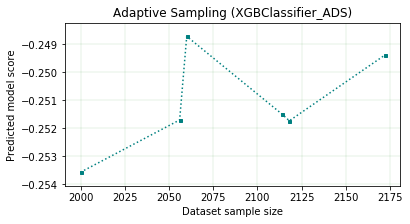

In [11]:
oracle_automl.visualize_adaptive_sampling_trials()

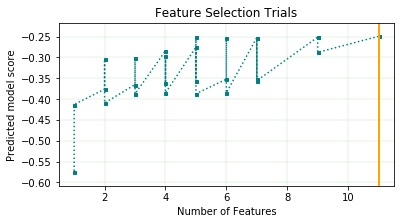

In [12]:
oracle_automl.visualize_feature_selection_trials()

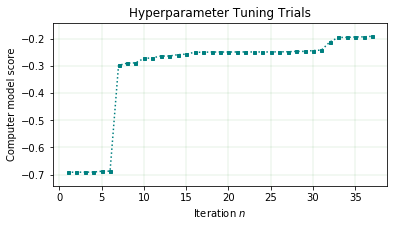

In [13]:
oracle_automl.visualize_tuning_trials()

<a id='eval'></a>
## Compare different generated models
A model trained using AutoML can easily be deployed into production, as it behaves similar to any standard Machine Learning model. We now evaluate the model on unseen data stored in test. We rename each of the generated AutoML models making them easier to visualize. 
We use ADSEvaluator to visualize behavior for each of the models on the test set, including the baseline.

HTML(value='<style  type="text/css" >\n    #T_73a47fc4_de65_11ea_8715_857745a7dc49  {\n          text-align: r…

HTML(value='<style  type="text/css" >\n    #T_73adc4b2_de65_11ea_8715_857745a7dc49  {\n          text-align: r…

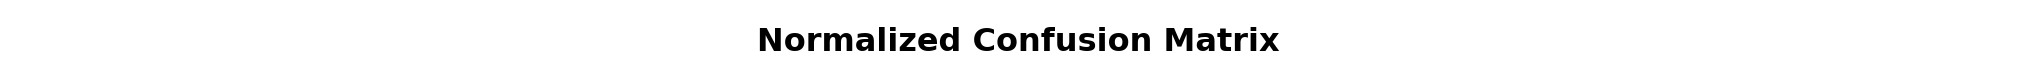

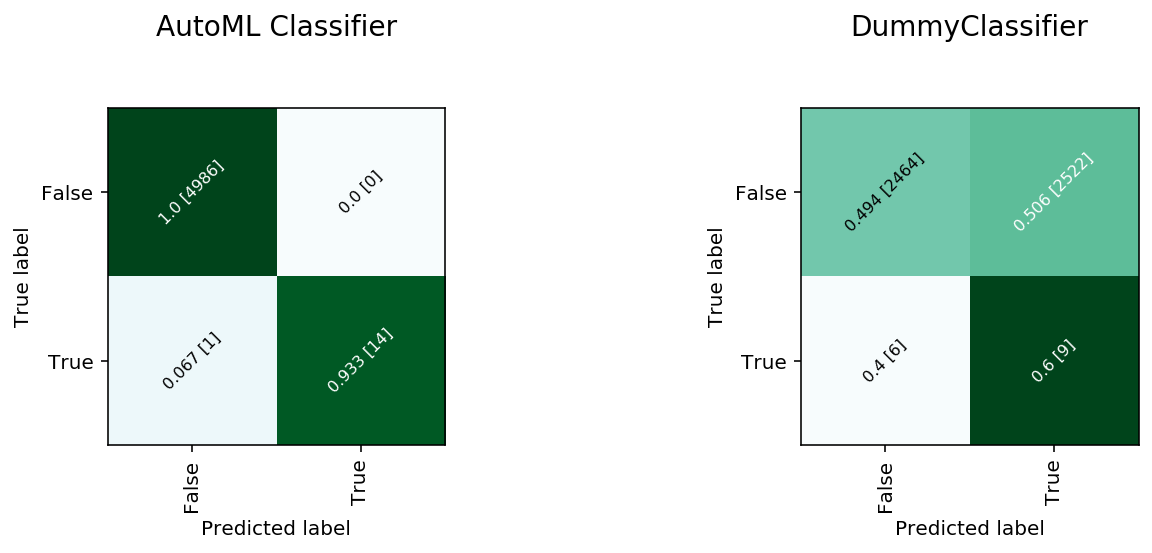

In [14]:
from ads.evaluations.evaluator import ADSEvaluator

evaluator = ADSEvaluator(test, models=[automl_xgb, baseline], training_data=train)
evaluator.show_in_notebook(plots=['normalized_confusion_matrix'])
evaluator.metrics

<a id='Sklearn'></a>
## Build a ML Model Using Scikit-learn

### Loading Necessary Libraries And Datasets

In [15]:
import pandas as pd
import sklearn 
import numpy as np

train = pd.read_csv('trainDataset.csv')
test = pd.read_csv('testDataset.csv')

### Data Exploration and Cleaning

In [16]:
train.head()

,Unnamed: 0,amount,latitude,longitude,transactionTimeStamp,CUSTOMER_ID,isCardPresent_true,merchantId_ChIJ-62dDRvGxokRSKE56Gje7SA,merchantId_ChIJ2ewYHlRYwokRfGm7d2DTg-U,merchantId_ChIJ36UlOPrPxokRKM7GxJatIBA,...,CUSTOMER_VALUE_SEGMENT_Gold,CUSTOMER_VALUE_SEGMENT_Silver,CUSTOMER_DMG_SEGMENT_Segment1,CUSTOMER_DMG_SEGMENT_Segment2,CUSTOMER_DMG_SEGMENT_Segment3,CUSTOMER_DMG_SEGMENT_Segment4,CUSTOMER_DMG_SEGMENT_Segment5,CREDIT_SCORE_BIN_Good Credit,CREDIT_SCORE_BIN_Other Credit,fraudFlag
0,162521,266.0,40.855565,-73.929398,1549808379,73084,1,0,0,0,...,0,1,0,0,1,0,0,0,1,False
1,11869,35.0,39.914424,-75.173187,1549085851,49519,1,0,0,0,...,0,1,0,1,0,0,0,1,0,False
2,159386,251.0,40.709438,-73.797467,1549046485,25106,1,0,0,0,...,0,1,0,1,0,0,0,1,0,False
3,166874,2002.0,40.749033,-73.986472,1550866087,40512,1,0,0,0,...,1,0,1,0,0,0,0,1,0,False
4,20564,42.0,40.067832,-74.854028,1551199486,59548,1,0,0,0,...,0,0,0,0,0,1,0,0,1,False


In [17]:
try:
    train.drop('Unnamed: 0', axis = 1, inplace = True)
    test.drop('Unnamed: 0', axis = 1, inplace = True)
except:
    train.dropna(how='any', axis = 0)
    test.dropna(how='any', axis =0)
    print('the dataset is clean')

### Train a Random Forest Model

In [18]:
X_train = train.drop('fraudFlag', axis = 1)
y_train = train['fraudFlag']

y_train.value_counts()

True     131721
False    131721
Name: fraudFlag, dtype: int64

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

# Visualize the result

In [20]:
X_test = test.drop('fraudFlag', axis = 1)
y_test = test['fraudFlag']

y_test.value_counts()

False    43915
True       389
Name: fraudFlag, dtype: int64

In [21]:
# Get predictions and compare to original values

y_pred = rfc.predict(X_test)
Validation = pd.DataFrame({})

# validation --to be input into adw
Validation['Original Value'] = y_test
Validation['Prediction'] = y_pred
Validation.head(10)
# Calculate metrics on the model's performance
from sklearn.metrics import classification_report, accuracy_score,f1_score
print('The model used is Random Forest classifier')
n_errors = (y_pred != y_test).sum()
print('The number of errors is {}'.format(n_errors))
acc= accuracy_score(y_test,y_pred)
print('The accuracy is {}'.format(acc))
f1= f1_score(y_test,y_pred, average = 'weighted')
print('The F1-Score is {}'.format(f1))

The model used is Random Forest classifier
The number of errors is 182
The accuracy is 0.9958920187793427
The F1-Score is 0.9957031630890235


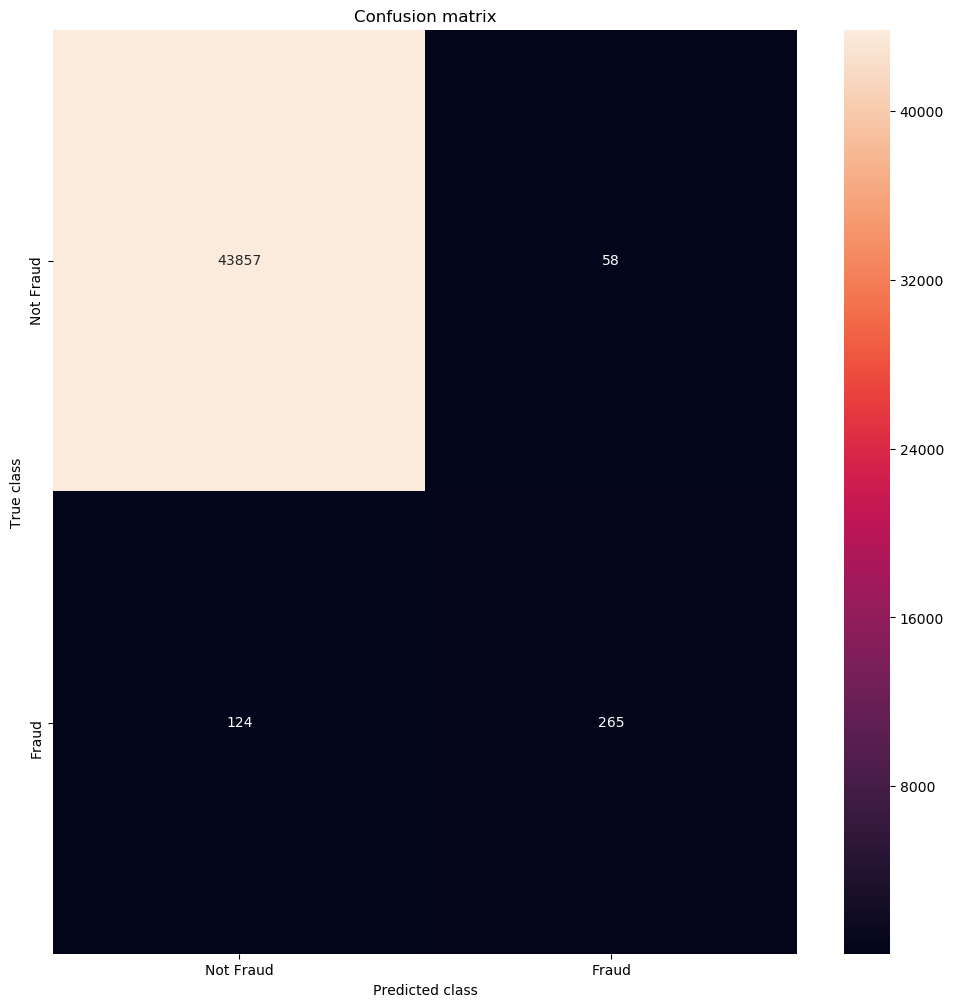

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

LABELS = ['Not Fraud', 'Fraud']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS,
 yticklabels=LABELS, annot=True, fmt='d');
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.show()

<a id='ModelCatalog'> </a>
## Save Models To Model Catalog

### Learn more about how to configure this with your instance

In [23]:
#navigate to File, then New Launcher, then Notebook Examples, then select model_catalog.ipynb

<a id ='ADB'></a>
## Create an ADB connection

In [24]:
#input environment variables here if you have an existing ADW and know your credentials
%env TNS_ADMIN=
%env ADW_SID=
%env ADW_USER=
%env ADW_PASSWORD=
!echo exit | sqlplus ${ADW_USER}/${ADW_PASSWORD}@${ADW_SID}

#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import logging
import os

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

uri = 'oracle+cx_oracle://' + os.environ["ADW_USER"] + ':' + os.environ["ADW_PASSWORD"] + '@' + os.environ["ADW_SID"]

env: TNS_ADMIN=
env: ADW_SID=
env: ADW_USER=
env: ADW_PASSWORD=

SQL*Plus: Release 19.0.0.0.0 - Production on Fri Aug 14 19:37:57 2020
Version 19.3.0.0.0

Copyright (c) 1982, 2019, Oracle.  All rights reserved.

ERROR:
ORA-12162: TNS:net service name is incorrectly specified


Enter user-name: Enter password: 
ERROR:
ORA-12162: TNS:net service name is incorrectly specified


Enter user-name: 

### Loading data into ADB using sqlalchemy

In [ ]:
#Note: this section will throw an error if you have not configured the earlier code cell block with ADW credentials

from sqlalchemy import create_engine

engine = create_engine(uri, max_identifier_length=128)

# don't need to create table in ADW 
test.to_sql('rf_prediction', engine, if_exists='replace')

### Query data from ADB

In [ ]:
#Note: this section will throw an error if you have not configured the earlier code cell block with ADW credentials

f = pd.read_sql("SELECT * from RF_PREDICTION", con=engine)

f.head(5)

## Consider Deploying your Models with Oracle Functions

In [27]:
# Refer to the bonus section for a detailed notebook on how to configure functions to deploy your models

<a id='ref'></a>
## References
Everything stored in the <span style="background-color: #d5d8dc ">/home/datascience</span> folder is now stored on your block volume drive. The <span style="background-color: #d5d8dc ">ads-examples</span> folder has moved outside of your working space. Notebook examples are now accessible through a Launcher tab "Notebook Examples" button.
<details>
<summary><font size="2">1. Check for Public Internet Access</font></summary>
```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">2. OCI Configuration and Key Files Set Up</font></summary><p>Follow the instructions in the getting-started notebook. That notebook is accessible via the "Getting Started" Launcher tab button.</p>
</details>
<details>
<summary><font size="2">3. Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">4. Typical Cell Imports and Settings</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import MLData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">5. Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>